In [1]:
from fastai.vision.all import *
from self_supervised.augmentations import *
from self_supervised.layers import *
from self_supervised.byol import *
from fastai.callback.wandb import WandbCallback
import wandb

## Pretraining

In [2]:
sqrmom=0.99
mom=0.95
beta=0.
eps=1e-4
opt_func = partial(ranger, mom=mom, sqr_mom=sqrmom, eps=eps, beta=beta)

In [3]:
def get_dls(size, bs, workers=None):
    path = URLs.IMAGEWANG_160 if size <= 160 else URLs.IMAGEWANG
    source = untar_data(path)
    
    files = get_image_files(source)
    tfms = [[PILImage.create, ToTensor, RandomResizedCrop(size, min_scale=1.)], 
            [parent_label, Categorize()]]
    
    dsets = Datasets(files, tfms=tfms, splits=RandomSplitter(valid_pct=0.1)(files))
    
    batch_tfms = [IntToFloatTensor]
    dls = dsets.dataloaders(bs=bs, num_workers=workers, after_batch=batch_tfms)
    return dls

In [4]:
bs=96
resize, size = 256, 224
use_wandb = False

In [5]:
arch = "xresnet34"
encoder = create_encoder(arch, pretrained=False, n_in=3)

In [6]:
if use_wandb:
    xtra_config = {"Arch":arch, "Resize":resize, "Size":size, "Algorithm":"BYOL"}
    wandb.init(project="self-supervised-imagewang", config=xtra_config);
    cbs += [WandbCallback(log_preds=False,log_model=False)]
else: cbs = []

In [7]:
cbs += [BYOL(0.9, 
              size,
              aug_func=get_batch_augs,
              rotate=True,
              rotate_deg=10,
              jitter=True,
              bw=True,
              blur=False
             ),
         TerminateOnNaNCallback()] 
dls = get_dls(resize, bs)
model = create_byol_model(encoder, n_in=3)
learn = Learner(dls, model, byol_loss, cbs=cbs)

Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> ColorJitter -> RandomGrayscale -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0} -> Normalize -- {'mean': tensor([[[[0.4850]],

         [[0.4560]],

         [[0.4060]]]], device='cuda:0'), 'std': tensor([[[[0.2290]],

         [[0.2240]],

         [[0.2250]]]], device='cuda:0'), 'axes': (0, 2, 3)}
Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> ColorJitter -> RandomGrayscale -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0} -> Normalize -- {'mean': tensor([[[[0.4850]],

         [[0.4560]],

         [[0.4060]]]], device='cuda:0'), 'std': tensor([[[[0.2290]],

         [[0.2240]],

         [[0.2250]]]], device='cuda:0'), 'axes': (0, 2, 3)}


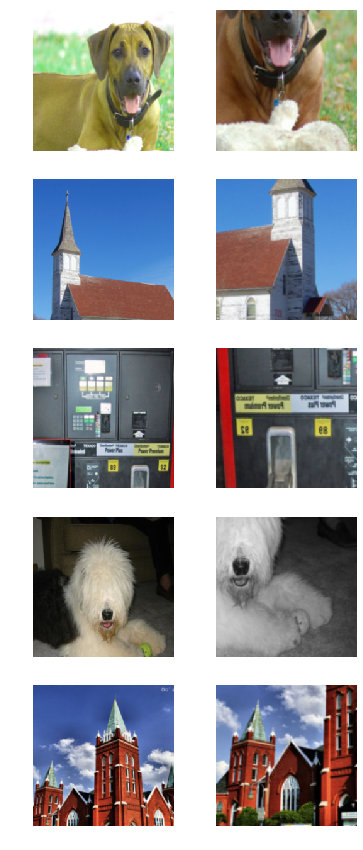

In [9]:
b = dls.one_batch()
learn._split(b)
learn('before_fit')
learn('before_batch')
learn.byol.show(n=5)

In [12]:
learn.to_fp16();

In [13]:
# learn.lr_find()

In [14]:
lr=1e-2
wd=1e-2
epochs=100

In [15]:
learn.unfreeze()
learn.fit_flat_cos(epochs, lr, wd=wd, pct_start=0.5)

epoch,train_loss,valid_loss,time
0,7.346763,7.319592,03:05
1,7.085961,7.102826,03:00
2,6.826987,7.432413,03:00
3,6.657548,6.684697,03:00
4,6.484780,6.750178,03:01
5,6.332900,6.453974,03:01
6,6.237092,6.448156,03:01
7,6.127450,6.266057,03:01
8,6.031301,6.170720,03:01
9,5.977430,6.152627,03:00


In [16]:
wandb.finish()

epoch,100
train_loss,4.80396
raw_loss,4.80031
wd_0,0.01
sqr_mom_0,0.99
lr_0,0.0
mom_0,0.9
eps_0,1e-05
_step,24699
_runtime,18095
_timestamp,1612839086


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss,█▇▆▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
raw_loss,█▇▆▅▄▅▄▄▃▃▃▂▃▃▃▂▂▃▃▃▂▃▃▂▂▃▂▂▁▁▂▂▁▂▁▂▁▃▁▁
wd_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sqr_mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,███████████████████████▇▇▇▆▆▅▅▄▄▃▃▂▂▂▁▁▁
mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


In [17]:
save_name = f'byol_iwang_sz{size}_epc{epochs}'
learn.save(save_name)
torch.save(learn.model.encoder.state_dict(), learn.path/learn.model_dir/f'{save_name}_encoder.pth')

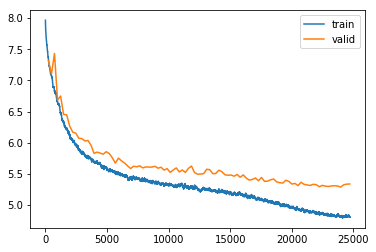

In [18]:
learn.recorder.plot_loss()

## Downstream Task

In [19]:
bs, size

(96, 224)

In [20]:
def get_dls(size, bs, workers=None):
    path = URLs.IMAGEWANG_160 if size <= 160 else URLs.IMAGEWANG
    source = untar_data(path)
    files = get_image_files(source, folders=['train', 'val'])
    splits = GrandparentSplitter(valid_name='val')(files)
    
    item_aug = [RandomResizedCrop(size, min_scale=0.35), FlipItem(0.5)]
    tfms = [[PILImage.create, ToTensor, *item_aug], 
            [parent_label, Categorize()]]
    
    dsets = Datasets(files, tfms=tfms, splits=splits)
    
    batch_tfms = [IntToFloatTensor, Normalize.from_stats(*imagenet_stats)]
    dls = dsets.dataloaders(bs=bs, num_workers=workers, after_batch=batch_tfms)
    return dls

In [ ]:
# def split_func(m): return L(m[0], m[1]).map(params)

def create_learner(size=size, arch='xresnet34', encoder_path=f'models/byol_iwang_sz{size}_epc100_encoder.pth'):
    
    dls = get_dls(size, bs=bs//2)
    pretrained_encoder = torch.load(encoder_path)
    encoder = create_encoder(arch, pretrained=False, n_in=3)
    encoder.load_state_dict(pretrained_encoder)
    nf = encoder(torch.randn(2,3,224,224)).size(-1)
    classifier = create_cls_module(nf, dls.c)
    model = nn.Sequential(encoder, classifier)
    learn = Learner(dls, model, opt_func=opt_func, splitter=split_func,
                metrics=[accuracy,top_k_accuracy], loss_func=LabelSmoothingCrossEntropy())
    return learn

In [22]:
def finetune(size, epochs, arch, encoder_path, lr=1e-2, wd=1e-2):
    learn = create_learner(size, arch, encoder_path)
    learn.unfreeze()
    learn.fit_flat_cos(epochs, lr, wd=wd)
    final_acc = learn.recorder.values[-1][-2]
    return final_acc

### 5 epochs

In [23]:
acc = []
runs = 5
for i in range(runs): acc += [finetune(size, epochs=5, arch='xresnet34', encoder_path=f'models/byol_iwang_sz{size}_epc100_encoder.pth')]

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.003726,1.702733,0.637312,0.902011,00:54
1,0.907711,1.588652,0.684907,0.920336,00:54
2,0.880427,1.381752,0.744973,0.945788,00:54
3,0.821257,1.412441,0.735047,0.944770,00:54
4,0.753851,1.245431,0.782896,0.959023,00:56


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,0.977824,1.644421,0.656656,0.904556,00:54
1,0.941114,1.702319,0.652838,0.910664,00:54
2,0.877325,1.466865,0.731993,0.939170,00:55
3,0.826462,1.414049,0.732756,0.944006,00:55
4,0.754504,1.248356,0.789005,0.963604,00:55


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,0.991975,1.696295,0.649020,0.912446,00:55
1,0.927800,1.564077,0.675999,0.914482,00:54
2,0.883308,1.452437,0.706032,0.953678,00:54
3,0.825139,1.405012,0.732247,0.944770,00:54
4,0.755022,1.269651,0.771189,0.959786,00:55


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,0.981242,1.705830,0.651820,0.918554,00:55
1,0.930540,1.530243,0.704250,0.932807,00:55
2,0.874156,1.428301,0.734538,0.944006,00:55
3,0.828597,1.432052,0.732756,0.944261,00:54
4,0.749793,1.270651,0.777043,0.957241,00:55


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,0.990188,1.664461,0.659964,0.913209,00:55
1,0.916905,1.746949,0.653347,0.919827,00:54
2,0.876274,1.540925,0.699160,0.928481,00:55
3,0.822780,1.427482,0.736065,0.945279,00:55
4,0.746668,1.283033,0.777297,0.957241,00:55


In [24]:
np.mean(acc)

0.7794858813285828

### 20 epochs

In [25]:
acc = []
runs = 3
for i in range(runs): acc += [finetune(size, epochs=5, arch='xresnet34', encoder_path=f'models/byol_iwang_sz{size}_epc100_encoder.pth')]
np.mean(acc)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,0.984659,1.648162,0.665818,0.928481,00:54
1,0.920816,1.480424,0.721303,0.933571,00:55
2,0.872141,1.387076,0.739119,0.947060,00:54
3,0.814974,1.395511,0.745482,0.946042,00:55
4,0.815932,1.444554,0.733520,0.936880,00:55
5,0.784586,1.364161,0.752100,0.949606,00:55
6,0.763978,1.464598,0.723085,0.945279,00:54
7,0.756061,1.513858,0.691016,0.928990,00:55
8,0.743778,1.414075,0.726139,0.938152,00:55
9,0.738189,1.410384,0.745482,0.953678,00:55


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,0.990826,1.926803,0.562739,0.896666,00:56
1,0.925727,1.520635,0.707559,0.939679,00:55
2,0.877482,1.419136,0.731993,0.946297,00:57
3,0.834636,1.372909,0.741156,0.940443,00:54
4,0.802381,1.417018,0.724103,0.950878,00:55
5,0.782618,1.384342,0.745228,0.955968,00:54
6,0.762937,1.416170,0.739883,0.945024,00:55
7,0.760333,1.416006,0.730720,0.948587,00:55
8,0.738668,1.327097,0.749555,0.944515,00:55
9,0.730946,1.483327,0.714686,0.935607,00:54


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,0.989855,1.620532,0.683635,0.914991,00:54
1,0.923530,1.533112,0.714177,0.934843,00:54
2,0.862308,1.643399,0.664546,0.925172,00:55
3,0.832433,1.360041,0.740901,0.949351,00:54
4,0.800033,1.378103,0.750827,0.939425,00:58
5,0.768974,1.396923,0.759481,0.939679,00:55
6,0.766265,1.413500,0.724866,0.934080,00:55
7,0.751104,1.383515,0.752354,0.949096,00:55
8,0.736254,1.407612,0.753881,0.942479,00:55
9,0.730978,1.415057,0.734793,0.935098,00:54


0.788919985294342

### 80 epochs

In [26]:
acc = []
runs = 1
for i in range(runs): acc += [finetune(size, epochs=5, arch='xresnet34', encoder_path=f'models/byol_iwang_sz{size}_epc100_encoder.pth')]
np.mean(acc)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.006964,1.835560,0.641385,0.883685,00:55
1,0.928978,1.511517,0.707050,0.934589,00:55
2,0.869080,1.435580,0.721558,0.944006,00:55
3,0.832356,1.475267,0.703741,0.941715,00:55
4,0.785432,1.527628,0.716467,0.941206,00:55
5,0.783196,1.392344,0.746500,0.946806,00:55
6,0.764544,1.376068,0.730720,0.937643,00:55
7,0.750309,1.455704,0.722576,0.935098,00:55
8,0.745672,1.381837,0.750827,0.945788,00:55
9,0.739380,1.433963,0.730466,0.939425,00:55


0.7579537034034729

### 200 epochs

In [ ]:
acc = []
runs = 1
for i in range(runs): acc += [finetune(size, epochs=5, arch='xresnet34', encoder_path=f'models/byol_iwang_sz{size}_epc100_encoder.pth')]
np.mean(acc)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,0.963223,1.624201,0.673454,0.932807,00:55
1,0.949285,1.703292,0.633495,0.873505,00:54
2,0.871079,1.506654,0.709341,0.941715,00:55
3,0.834461,1.515007,0.704759,0.929244,00:54
4,0.802906,1.325958,0.759990,0.954696,00:55
5,0.773226,1.405822,0.739119,0.945279,00:54
6,0.752312,1.440087,0.724866,0.926953,00:55
7,0.755499,1.418935,0.742937,0.948333,00:55
8,0.746847,1.398286,0.734284,0.935862,00:54
9,0.737169,1.443338,0.721049,0.942988,00:55


In [29]:
np.mean(acc)

0.7243573665618896